# Added mass

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using LinearAlgebra

### First, some generalities

In [20]:
𝐞₁ = [1;0];
𝐞₂ = [0;1];

#### First create a grid and a Laplacian operator on it

In [26]:
nx = 512; ny = 512;
Lx = 9.4;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [27]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 512, ny = 512) grid with spacing 1.0

#### Now create a circular shape, with discrete points and associated regularization and interpolation operator

In [37]:
n = 800

R = 1.0
body = Ellipse(R,R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the ellipse
xc = 4.7; yc = 4.7
T = RigidTransform((xc,yc),0.0)
T(body)

# Area of the ellipse
𝒱 = π*body.a*body.b

3.141592653589793

#### Set up the coordinates and other useful vectors

In [38]:
X = VectorData(body.x,body.y)
f = ScalarData(X);

In [39]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 0.42611918492359685


In [40]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [41]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 800 constraints and
   State of type Nodes{Dual,512,512}
   Force of type ScalarData{800}


#### Create some data structures for general use

In [42]:
ψb = ScalarData(X)
w = Nodes(Dual,(nx,ny))
ψ = Nodes(Dual,w);

### Solve flow generated by a translating cylinder

In [43]:
U = 1;
V = 0;

In [44]:
ψb .= U*(body.y .- body.cent[2]) - V*(body.x .- body.cent[1])
@time ψ,f = PS\(w,ψb)

  0.070265 seconds (104 allocations: 18.097 MiB, 7.16% gc time)


(Dual nodes in a (nx = 512, ny = 512) cell grid
  Number of Dual nodes: (nx = 512, ny = 512), [0.0, 0.000124848, 0.000249688, 0.000374512, 0.000499314, 0.000624084, 0.000748816, 0.000873502, 0.000998134, 0.0011227  …  -0.00124721, -0.0011227, -0.000998134, -0.000873502, -0.000748816, -0.000624084, -0.000499314, -0.000374512, -0.000249688, -0.000124848])

#### Plot the result

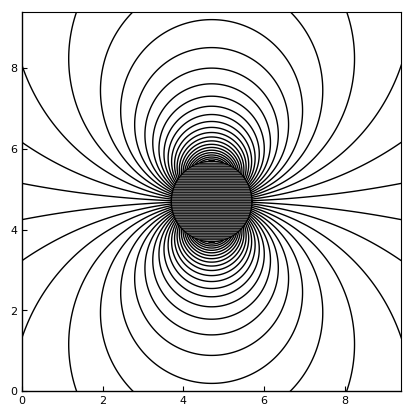

In [48]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=50))
plot!(body,fillcolor=:gray,fillrange=0,fillalpha=0.25,linecolor=:black)
plot!(xlims=(0,Lx),ylims=(0,Lx),legend=false,size=[400,400])
savefig("added_mass_1_body.pdf")

#### Check added mass coefficient

In [46]:
"""
integrate(f::Function,xmin::Real,xmax::Real,N::Int,name::String) -> Real
Integrate the function `f` between the limits `xmin` to `xmax` with `N` intervals using either the `"trapezoidal"` or `"simpson"` rule specified in `name`. The solution is returned as a Real value.
"""
function surface_integrate(body::Body{N},integrand::Array{Float64,1}) where {N}
    func = Array{Float64,1}(undef, N+1)
    func[1:end-1] .= integrand
    func[end] = integrand[1]
    s = sum(Bodies.dlength(body).*(func[1:end-1] + func[2:end]))
    return s
end

surface_integrate

In [17]:
integrand_x = (f./Bodies.dlength(body)).*(body.y);
integrand_y = -(f./Bodies.dlength(body)).*(body.x);

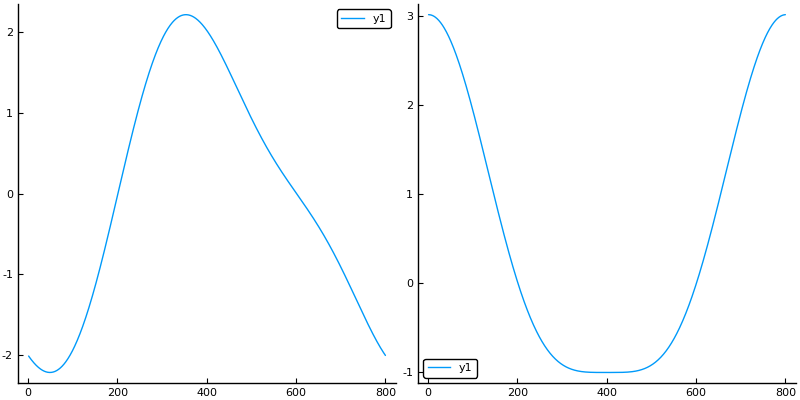

In [18]:
p1 = plot(integrand_x)
p2 = plot(integrand_y)
p3 = plot(p1,p2,layout=(1,2),size=[800,400])

In [19]:
# P¹ = -𝒱*𝐞₁ + 0.5*[surface_integrate(body,integrand_x);surface_integrate(body,integrand_y)]
P² = -𝒱*𝐞₂ + 0.5*[surface_integrate(body,integrand_x);surface_integrate(body,integrand_y)]

2-element Array{Float64,1}:
 2.220446049250313e-16
 0.7933500241533995   

In [52]:
M₁₁ = dot(P¹,𝐞₁)

0.7898799088877646

Compare the generated vortex sheet `f/ds` with the exact solution

In [37]:
θ = range(0,2π,length=n+1)
fex = 2*sin.(θ[1:n]);
errinf = LinearAlgebra.norm(f./ds-fex,Inf)

0.0057922204682880896

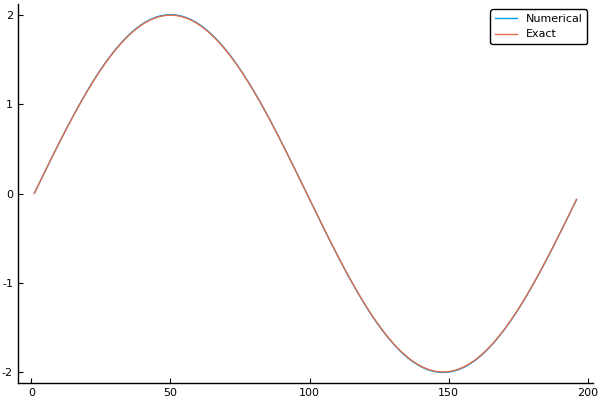

In [38]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")